🔹 DECISION ALGORITHM 3: Actor–Critic (Advanced Strategy Learning)

In [1]:
%pip install pennylane pennylane-lightning torch scikit-learn matplotlib

Note: you may need to restart the kernel to use updated packages.


## 3A. Classical Actor–Critic

In [2]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import pandas as pd
import pennylane as qml


In [3]:
STATE_DIM = 4
ACTION_DIM = 2
EPISODES = 200
STEPS_PER_EPISODE = 20


In [4]:
def environment_step(action):
    # action 1 slightly better than action 0
    reward_probs = [0.4, 0.6]
    return 1 if np.random.rand() < reward_probs[action] else 0


In [5]:
metrics_classical = {
    "progress": [],
    "performance": []
}

metrics_quantum = {
    "progress": [],
    "performance": []
}


In [6]:
actor = nn.Sequential(
    nn.Linear(STATE_DIM, 8),
    nn.ReLU(),
    nn.Linear(8, ACTION_DIM),
    nn.Softmax(dim=-1)
)

critic = nn.Sequential(
    nn.Linear(STATE_DIM, 8),
    nn.ReLU(),
    nn.Linear(8, 1)
)

optimizer = torch.optim.Adam(
    list(actor.parameters()) + list(critic.parameters()),
    lr=0.01
)


In [7]:
for episode in range(EPISODES):

    episode_reward = 0
    state = torch.rand(STATE_DIM)

    for step in range(STEPS_PER_EPISODE):
        probs = actor(state)
        action = torch.multinomial(probs, 1).item()

        reward = environment_step(action)
        next_state = torch.rand(STATE_DIM)

        value = critic(state)
        next_value = critic(next_state)

        advantage = reward + 0.95 * next_value - value

        actor_loss = -torch.log(probs[action]) * advantage.detach()
        critic_loss = advantage.pow(2)

        loss = actor_loss + critic_loss

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        episode_reward += reward
        state = next_state

    # 🔴 METRIC COLLECTION (SVM-STYLE)
    metrics_classical["progress"].append(episode)
    metrics_classical["performance"].append(episode_reward)


## 3B. Quantum Actor–Critic

Actor = quantum policy, Critic = quantum value

In [8]:
N_QUBITS = 2
dev = qml.device("default.qubit", wires=N_QUBITS)

@qml.qnode(dev, interface="torch")
def quantum_actor(state, weights):
    qml.AngleEmbedding(state[:N_QUBITS], wires=range(N_QUBITS))
    qml.BasicEntanglerLayers(weights, wires=range(N_QUBITS))
    return [qml.expval(qml.PauliZ(i)) for i in range(N_QUBITS)]

@qml.qnode(dev, interface="torch")
def quantum_critic(state, weights):
    qml.AngleEmbedding(state[:N_QUBITS], wires=range(N_QUBITS))
    qml.BasicEntanglerLayers(weights, wires=range(N_QUBITS))
    return qml.expval(qml.PauliZ(0))


In [9]:
actor_weights = torch.nn.Parameter(torch.randn(2, N_QUBITS))
critic_weights = torch.nn.Parameter(torch.randn(2, N_QUBITS))

optimizer_q = torch.optim.Adam(
    [actor_weights, critic_weights],
    lr=0.1
)


In [10]:
for episode in range(EPISODES):

    episode_reward = 0
    state = torch.rand(STATE_DIM)

    for step in range(STEPS_PER_EPISODE):
        logits = torch.stack(quantum_actor(state, actor_weights))
        probs = torch.softmax(logits, dim=0)

        action = torch.multinomial(probs, 1).item()
        reward = environment_step(action)
        next_state = torch.rand(STATE_DIM)

        value = quantum_critic(state, critic_weights)
        next_value = quantum_critic(next_state, critic_weights)

        advantage = reward + 0.95 * next_value - value

        actor_loss = -torch.log(probs[action]) * advantage.detach()
        critic_loss = advantage.pow(2)

        loss = actor_loss + critic_loss

        optimizer_q.zero_grad()
        loss.backward()
        optimizer_q.step()

        episode_reward += reward
        state = next_state

    # 🔴 METRIC COLLECTION (MATCHES CLASSICAL)
    metrics_quantum["progress"].append(episode)
    metrics_quantum["performance"].append(episode_reward)


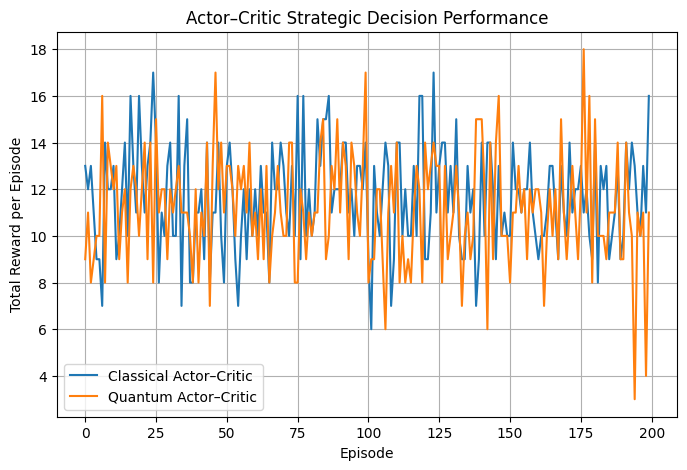

In [11]:
plt.figure(figsize=(8, 5))
plt.plot(metrics_classical["progress"],
         metrics_classical["performance"],
         label="Classical Actor–Critic")

plt.plot(metrics_quantum["progress"],
         metrics_quantum["performance"],
         label="Quantum Actor–Critic")

plt.xlabel("Episode")
plt.ylabel("Total Reward per Episode")
plt.title("Actor–Critic Strategic Decision Performance")
plt.legend()
plt.grid(True)
plt.show()


In [12]:
results = pd.DataFrame({
    "Model": ["Classical Actor–Critic", "Quantum Actor–Critic"],
    "Average Episode Reward": [
        np.mean(metrics_classical["performance"]),
        np.mean(metrics_quantum["performance"])
    ],
    "Final Episode Reward": [
        metrics_classical["performance"][-1],
        metrics_quantum["performance"][-1]
    ]
})

results


,Model,Average Episode Reward,Final Episode Reward
0,Classical Actor–Critic,11.660,16
1,Quantum Actor–Critic,11.165,11


**Paper framing:**
“Quantum actor–critic architectures combine quantum policy learning with quantum value estimation.”